In [1]:
!nvidia-smi -q


==============NVSMI LOG==============

Timestamp                                 : Tue Feb  3 13:53:59 2026
Driver Version                            : 550.54.15
CUDA Version                              : 12.4

Attached GPUs                             : 1
GPU 00000000:00:04.0
    Product Name                          : Tesla T4
    Product Brand                         : NVIDIA
    Product Architecture                  : Turing
    Display Mode                          : Enabled
    Display Active                        : Disabled
    Persistence Mode                      : Disabled
    Addressing Mode                       : None
    MIG Mode
        Current                           : N/A
        Pending                           : N/A
    Accounting Mode                       : Disabled
    Accounting Mode Buffer Size           : 4000
    Driver Model
        Current                           : N/A
        Pending                           : N/A
    Serial Number                 

In [2]:
import os
from subprocess import run, PIPE

cuda_filename = 'levenshtein_cuda.cu'
library_name = 'levenshtein_lib.so'

cuda_code = """
#include <iostream>
#include <chrono>
#include <map>
#include <vector>
#include <string>
#include <algorithm>
#include <ctime>
#include <cstdlib>
#include <cstring>
#include <fstream>
#include <cuda_runtime.h>

#define nTests 10
#define MIN3(a, b, c) (min(min(a, b), c))

//random word generation
std::string generateWord(int n) {
    std::string word = "";
    for (int i = 0; i < n; i++) word += (char)('a' + rand() % 26);
    return word;
}

int sequentialDistance(std::string A, std::string B) {
    int lenA = A.size();
    int lenB = B.size();
    std::vector<int> prev(lenB + 1);
    std::vector<int> curr(lenB + 1);
    for (int j = 0; j <= lenB; j++) prev[j] = j;
    for (int i = 1; i <= lenA; i++) {
        curr[0] = i;
        for (int j = 1; j <= lenB; j++) {
            int cost = (A[i - 1] == B[j - 1]) ? 0 : 1;
            curr[j] = std::min({curr[j - 1] + 1, prev[j] + 1, prev[j - 1] + cost});
        }
        prev = curr;
    }
    return prev[lenB];
}

//kernel for rectangular matrices (antidiagonals)
__global__ void levKernel(const char *s1, const char *s2, int len1, int len2,
                               unsigned int *pprev, unsigned int *prev,
                               unsigned int *curr, int k) {

    //i = row, j = column. Diagonal k = i + j
    int i_min = max(1, k - len2);
    int i_max = min(k - 1, len1);
    int diagSize = i_max - i_min + 1;

    int tid = blockIdx.x * blockDim.x + threadIdx.x;

    if (tid < diagSize) {
        int i = i_min + tid;
        int j = k - i;

        int cost = (s1[i - 1] == s2[j - 1]) ? 0 : 1;

        //mapping of indexes in the buffers of the previous diagonals
        //relative offsets to find (i-1, j), (i, j-1), and (i-1, j-1)
        int i_start_prev = max(1, (k - 1) - len2);
        int i_start_pprev = max(1, (k - 2) - len2);

        unsigned int del = prev[i - 1 - i_start_prev + ( (k-1) > len2 ? 1 : 0 )] + 1;
        unsigned int ins = prev[tid + (k > len2 + 1 ? 1 : 0)] + 1;
        unsigned int sub = pprev[tid + (k > len2 + 1 ? 1 : ( (k-1) > len2 ? 1 : 0 )) ] + cost;

        //indexing simplification
        int idx_prev_up = i - 1 - max(0, (k-1) - len2);
        int idx_prev_left = i - max(0, (k-1) - len2);
        int idx_pprev_diag = i - 1 - max(0, (k-2) - len2);

        curr[i - max(0, k - len2)] = MIN3(prev[idx_prev_up] + 1,
                                          prev[idx_prev_left] + 1,
                                          pprev[idx_pprev_diag] + cost);
    }
}

int parallelDistance(const char *A, const char *B, int lenA, int lenB, int maxBlockSize) {
    if (lenA == 0) return lenB;
    if (lenB == 0) return lenA;

    char *devA, *devB;
    unsigned int *d_pprev, *d_prev, *d_curr;
    int max_dim = lenA + lenB + 1;

    cudaMalloc(&devA, lenA);
    cudaMalloc(&devB, lenB);
    cudaMalloc(&d_pprev, max_dim * sizeof(unsigned int));
    cudaMalloc(&d_prev, max_dim * sizeof(unsigned int));
    cudaMalloc(&d_curr, max_dim * sizeof(unsigned int));

    cudaMemcpy(devA, A, lenA, cudaMemcpyHostToDevice);
    cudaMemcpy(devB, B, lenB, cudaMemcpyHostToDevice);

    //edge initialization (diagonal 0 (0,0) and Diagonal 1 (1,0 and 0,1))
    unsigned int h_init0 = 0;
    unsigned int h_init1[2] = {1, 1};
    cudaMemcpy(d_pprev, &h_init0, sizeof(unsigned int), cudaMemcpyHostToDevice);
    cudaMemcpy(d_prev, h_init1, 2 * sizeof(unsigned int), cudaMemcpyHostToDevice);

    for (int k = 2; k <= lenA + lenB; k++) {
        int i_min = max(0, k - lenB);
        int i_max = min(k, lenA);
        int diagSize = i_max - i_min + 1;

        //loading edges (i,0) and (0,j)
        unsigned int val_k = (unsigned int)k;
        if (i_min == 0) cudaMemcpy(&d_curr[0], &val_k, sizeof(unsigned int), cudaMemcpyHostToDevice);
        if (i_max == k) cudaMemcpy(&d_curr[diagSize - 1], &val_k, sizeof(unsigned int), cudaMemcpyHostToDevice);

        //kernel for internal cells
        int internal_start = max(1, k - lenB);
        int internal_end = min(k - 1, lenA);
        int internal_size = internal_end - internal_start + 1;

        if (internal_size > 0) {
            int blockSize = min(internal_size, maxBlockSize);
            int gridSize = (internal_size + blockSize - 1) / blockSize;
            levKernel<<<gridSize, blockSize>>>(devA, devB, lenA, lenB, d_pprev, d_prev, d_curr, k);
        }
        cudaDeviceSynchronize();

        unsigned int *tmp = d_pprev; d_pprev = d_prev; d_prev = d_curr; d_curr = tmp;
    }

    unsigned int result;
    cudaMemcpy(&result, d_prev, sizeof(unsigned int), cudaMemcpyDeviceToHost);

    cudaFree(devA); cudaFree(devB);
    cudaFree(d_pprev); cudaFree(d_prev); cudaFree(d_curr);
    return (int)result;
}

extern "C" void free_cuda_memory(void* ptr) { delete[] (float*)ptr; }

extern "C" float* run_tests(const int* sizes, int n_sizes, const int* blockSizes, int n_blockSizes) {
    srand(time(NULL));
    //remove the previous debug file if exists
    std::remove("strings_debug.txt");

    float* output = new float[n_sizes + 2 * (n_sizes * n_blockSizes)];
    int output_idx = 0;
    std::vector<float> seq_times;
    std::map<int, std::vector<float>> par_times;

    for (int i = 0; i < n_sizes; i++) {
        int n = sizes[i];
        std::vector<std::string> Awords, Bwords;
        std::vector<int> lensA, lensB;

        for (int j = 0; j < nTests; j++) {
            int lenA = n;
            int lenB = n / 2 + rand() % n;
            Awords.push_back(generateWord(lenA));
            Bwords.push_back(generateWord(lenB));
            lensA.push_back(lenA);
            lensB.push_back(lenB);

            //debug strings
            std::ofstream out("strings_debug.txt", std::ios::app);
            out << "Test " << j+1 << " (Size " << n << "):\\n";
            out << "A (" << lenA << "): " << Awords[j].substr(0,30) << "...\\n";
            out << "B (" << lenB << "): " << Bwords[j].substr(0,30) << "...\\n\\n";
            out.close();
        }

        auto start = std::chrono::system_clock::now();
        for (int j = 0; j < nTests; j++) sequentialDistance(Awords[j], Bwords[j]);
        seq_times.push_back(std::chrono::duration_cast<std::chrono::milliseconds>(std::chrono::system_clock::now() - start).count() / (float)nTests);

        for (int k = 0; k < n_blockSizes; k++) {
            int bs = blockSizes[k];
            start = std::chrono::system_clock::now();
            for (int j = 0; j < nTests; j++) parallelDistance(Awords[j].c_str(), Bwords[j].c_str(), lensA[j], lensB[j], bs);
            par_times[bs].push_back(std::chrono::duration_cast<std::chrono::milliseconds>(std::chrono::system_clock::now() - start).count() / (float)nTests);
        }
    }

    for (float t : seq_times) output[output_idx++] = t;
    for (int k = 0; k < n_blockSizes; k++) for (float t : par_times[blockSizes[k]]) output[output_idx++] = t;
    for (int k = 0; k < n_blockSizes; k++) for (int i = 0; i < n_sizes; i++) output[output_idx++] = seq_times[i] / par_times[blockSizes[k]][i];

    return output;
}
"""

with open(cuda_filename, 'w') as f:
    f.write(cuda_code)

compile_command = f"nvcc -o {library_name} {cuda_filename} -shared -Xcompiler -fPIC -std=c++11"
result = run(compile_command, shell=True, stdout=PIPE, stderr=PIPE)
if result.returncode != 0:
    print("ERRORE COMPILAZIONE!")
    print(result.stderr.decode())
else:
    print(f"Libreria '{library_name}' creata correttamente.")


Libreria 'levenshtein_lib.so' creata correttamente.


In [3]:
import numpy as np
import ctypes
from ctypes import c_int, POINTER, c_float

library_name = 'levenshtein_lib.so'

#load library
cuda_lib = ctypes.CDLL(f"./{library_name}")

cuda_lib.run_tests.argtypes = [
    POINTER(c_int),
    c_int,
    POINTER(c_int),
    c_int
]
cuda_lib.run_tests.restype = POINTER(c_float)

cuda_lib.free_cuda_memory.argtypes = [ctypes.c_void_p]
cuda_lib.free_cuda_memory.restype = None

x_axes = np.array([100, 1000, 5000, 10000, 20000, 40000], dtype=np.int32)
blockSizes = np.array([32, 64, 128, 256, 512, 1024], dtype=np.int32)

result_ptr = cuda_lib.run_tests(
    x_axes.ctypes.data_as(POINTER(c_int)),
    c_int(len(x_axes)),
    blockSizes.ctypes.data_as(POINTER(c_int)),
    c_int(len(blockSizes))
)

total_expected_results = len(x_axes) * (1 + 2 * len(blockSizes))
results_array = np.asarray(result_ptr[:total_expected_results])
cuda_lib.free_cuda_memory(result_ptr)

#organization of results
seq_times = results_array[0 : len(x_axes)]
current_idx = len(x_axes)

times = {'Sequential': seq_times.tolist()}
for bs in blockSizes:
    key = f'{bs} block size'
    times[key] = results_array[current_idx : current_idx + len(x_axes)].tolist()
    current_idx += len(x_axes)

speedups = {}
for bs in blockSizes:
    key = f'{bs} block size'
    speedups[key] = results_array[current_idx : current_idx + len(x_axes)].tolist()
    current_idx += len(x_axes)

print("Tempi (ms):", times)
print("Speedup (x):", speedups)


with open("strings_debug.txt") as f:
    print(f.read())

Tempi (ms): {'Sequential': [0.4000000059604645, 45.099998474121094, 1178.4000244140625, 4619.10009765625, 17057.30078125, 74445.703125], '32 block size': [30.899999618530273, 14.199999809265137, 67.19999694824219, 133.3000030517578, 256.70001220703125, 536.9000244140625], '64 block size': [1.2999999523162842, 13.800000190734863, 67.69999694824219, 132.8000030517578, 255.89999389648438, 570.7999877929688], '128 block size': [1.399999976158142, 13.899999618530273, 67.80000305175781, 132.8000030517578, 283.29998779296875, 537.0999755859375], '256 block size': [1.2999999523162842, 14.0, 66.9000015258789, 156.60000610351562, 265.29998779296875, 568.2000122070312], '512 block size': [1.399999976158142, 13.800000190734863, 67.9000015258789, 142.89999389648438, 257.5, 536.4000244140625], '1024 block size': [1.2999999523162842, 13.800000190734863, 67.5999984741211, 132.89999389648438, 257.29998779296875, 560.7999877929688]}
Speedup (x): {'32 block size': [0.012944984249770641, 3.176056385040283

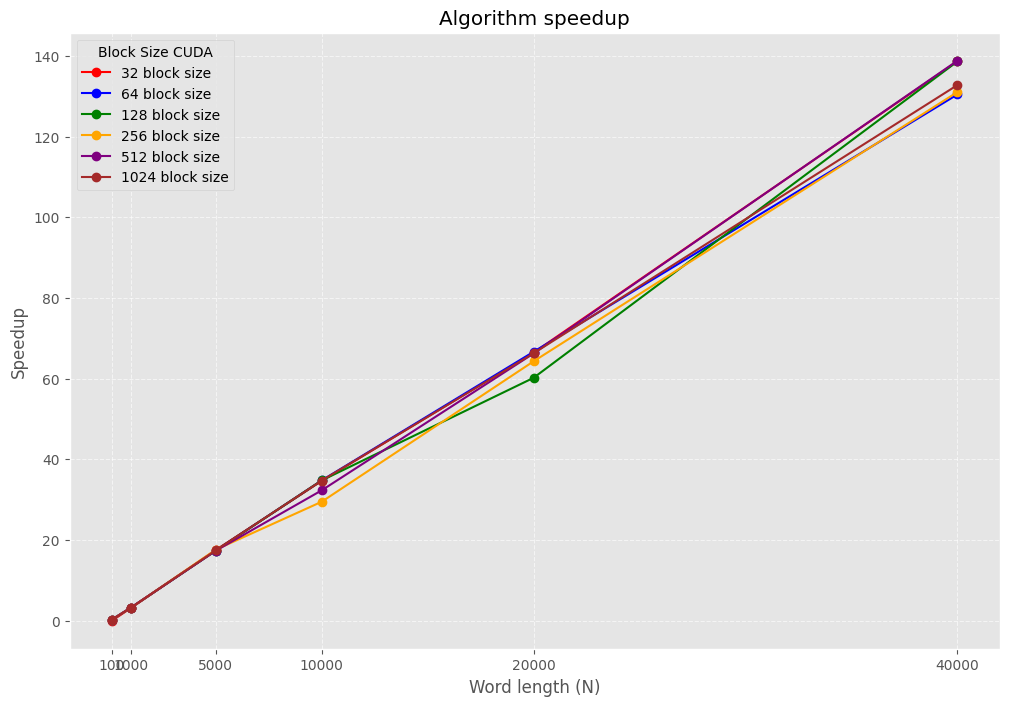

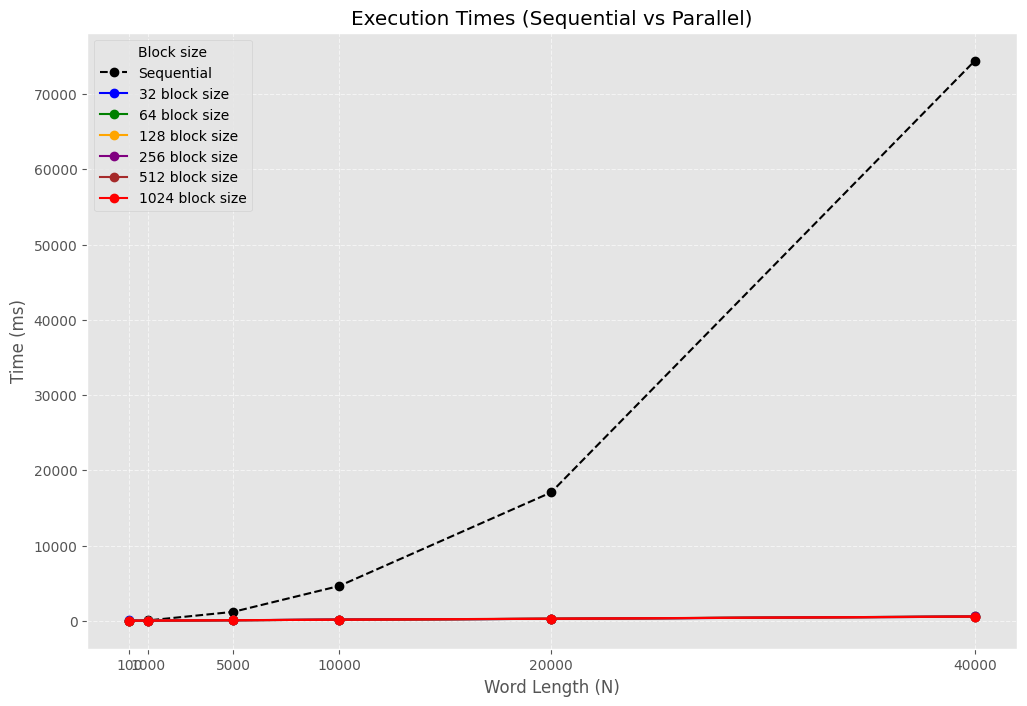

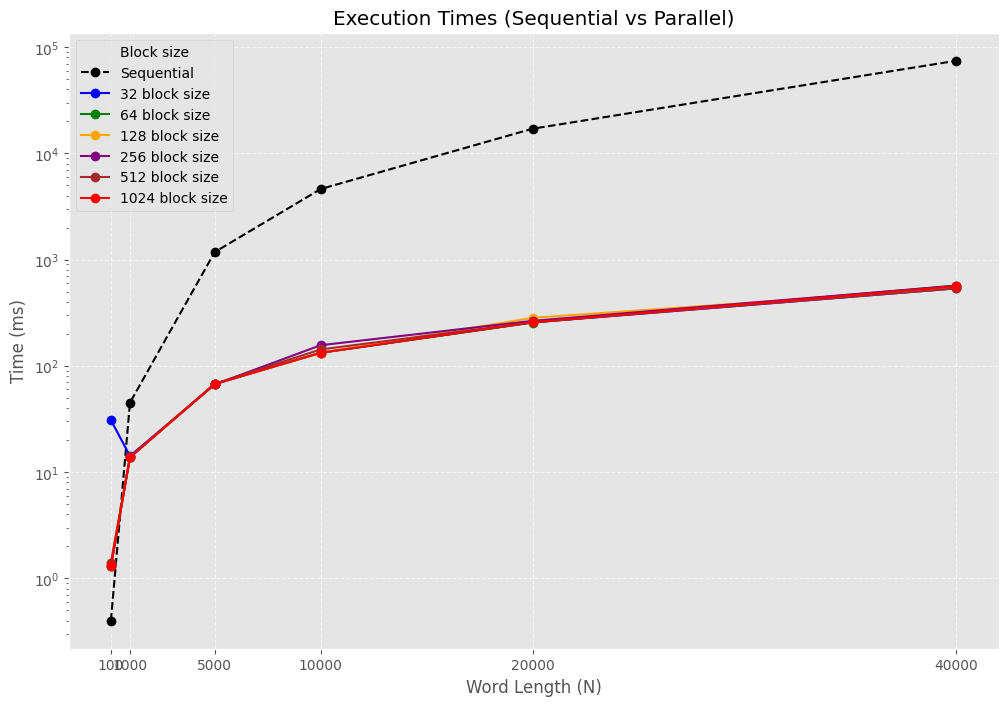

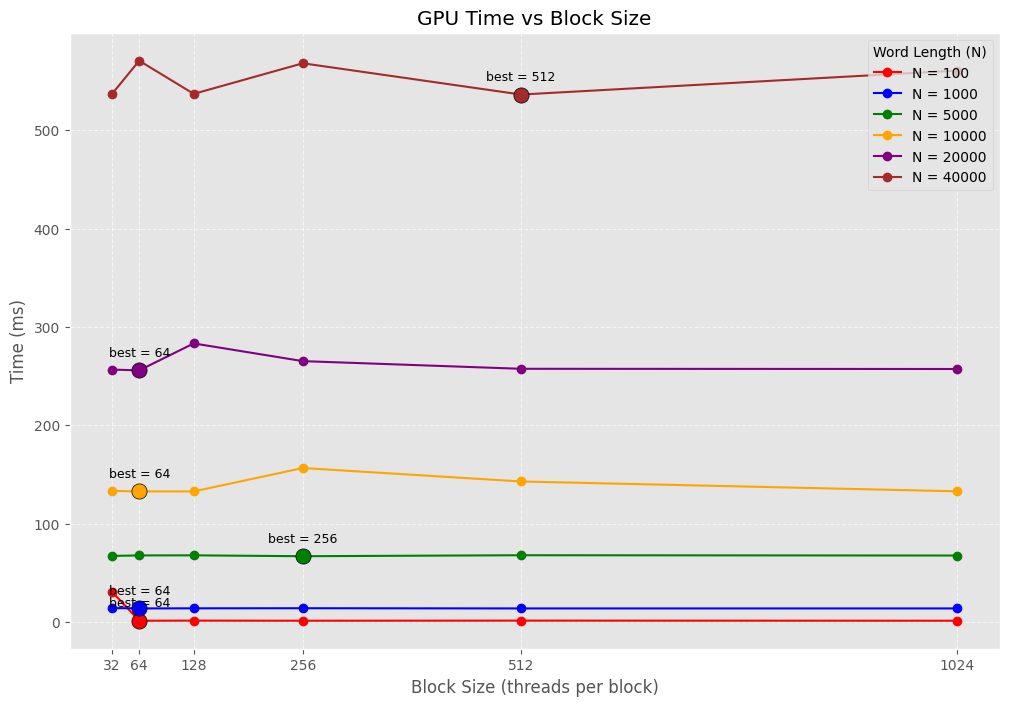

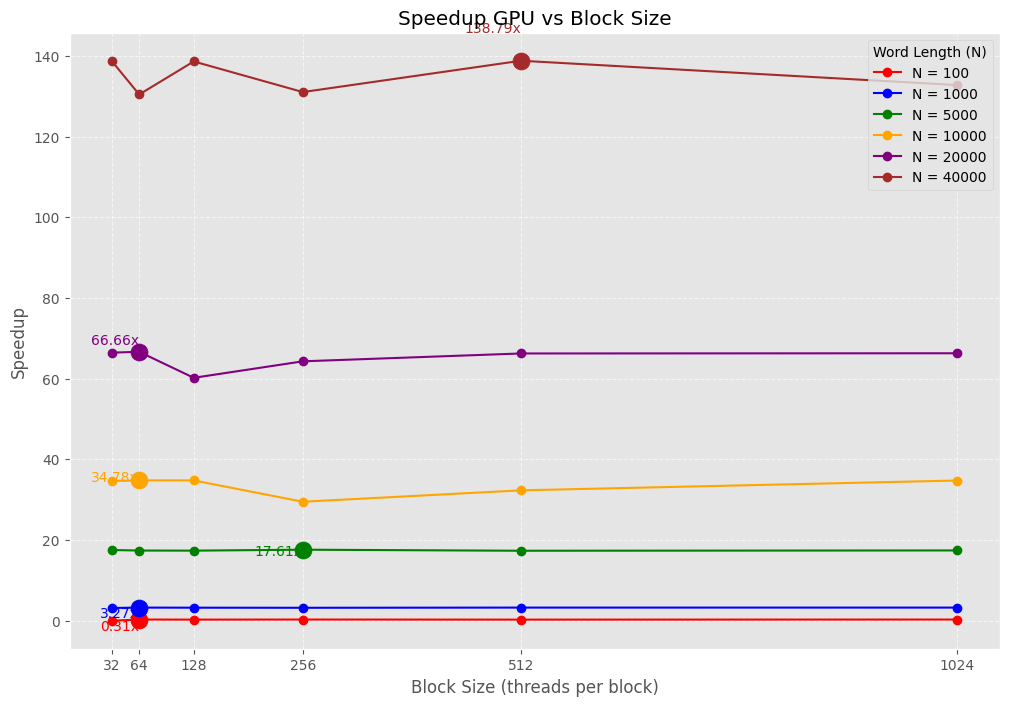

In [12]:
import matplotlib.pyplot as plt

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

#speedup graph
plt.figure(figsize=(12, 8))
plt.style.use('ggplot')
for idx, (key, speedup) in enumerate(speedups.items()):
    plt.plot(x_axes, speedup, label=key, color=colors[idx % len(colors)], marker='o')

plt.title("Algorithm speedup")
plt.xlabel("Word length (N)")
plt.xticks(x_axes)
plt.ylabel("Speedup")
plt.legend(title="Block Size CUDA")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

#time graph
plt.figure(figsize=(12, 8))
all_times_keys = list(times.keys())
for idx, key in enumerate(all_times_keys):
    time_values = times[key]
    color = 'black' if 'Sequential' in key else colors[idx % len(colors)]
    style = 'dashed' if 'Sequential' in key else 'solid'
    plt.plot(x_axes, time_values, label=key, color=color, linestyle=style, marker='o')

plt.title("Execution Times (Sequential vs Parallel)")
plt.xlabel("Word Length (N)")
plt.xticks(x_axes)
plt.ylabel("Time (ms)")
plt.legend(title="Block size")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

#time graph log
plt.figure(figsize=(12, 8))
all_times_keys = list(times.keys())
for idx, key in enumerate(all_times_keys):
    time_values = times[key]
    color = 'black' if 'Sequential' in key else colors[idx % len(colors)]
    style = 'dashed' if 'Sequential' in key else 'solid'
    plt.plot(x_axes, time_values, label=key, color=color, linestyle=style, marker='o')

plt.title("Execution Times (Sequential vs Parallel)")
plt.xlabel("Word Length (N)")
plt.xticks(x_axes)
plt.ylabel("Time (ms)")
plt.legend(title="Block size")
plt.grid(True, linestyle='--', alpha=0.6)
plt.yscale('log')
plt.show()

######################################à
##### altro grafico #####

plt.figure(figsize=(12, 8))
plt.style.use('ggplot')

for i, N in enumerate(x_axes):
    par_times_for_N = [
        times[f'{bs} block size'][i] for bs in blockSizes
    ]

    par_times_for_N = np.array(par_times_for_N)

    #best block size
    min_idx = np.argmin(par_times_for_N)
    best_bs = blockSizes[min_idx]
    best_time = par_times_for_N[min_idx]

    plt.plot(
        blockSizes,
        par_times_for_N,
        marker='o',
        color=colors[i % len(colors)],
        label=f'N = {N}'
    )

    #highlight minimum
    plt.scatter(
        best_bs,
        best_time,
        s=120,
        color=colors[i % len(colors)],
        edgecolors='black',
        zorder=5
    )

    plt.annotate(
        f'best = {best_bs}',
        (best_bs, best_time),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        fontsize=9
    )

plt.title('GPU Time vs Block Size')
plt.xlabel('Block Size (threads per block)')
plt.ylabel('Time (ms)')
plt.xticks(blockSizes)
plt.legend(title='Word Length (N)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

########### altro grafico ###############

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.style.use('ggplot')

for i, N in enumerate(x_axes):
    speedup_for_N = []

    for bs in blockSizes:
        key = f'{bs} block size'
        speedup_for_N.append(speedups[key][i])

    line_color = colors[i % len(colors)]

    plt.plot(
        blockSizes,
        speedup_for_N,
        marker='o',
        color=line_color,
        label=f'N = {N}'
    )

    #highlight the maximum speedup
    max_idx = speedup_for_N.index(max(speedup_for_N))
    plt.scatter(
        blockSizes[max_idx],
        speedup_for_N[max_idx],
        color=line_color,
        s=150,
        zorder=5
    )

    #text above the maximum
    plt.text(
        blockSizes[max_idx] - 0.05,
        speedup_for_N[max_idx] + 0.07 * max(speedup_for_N),
        f"{speedup_for_N[max_idx]:.2f}x",
        ha='right',
        va='top',
        fontsize=10,
        color=line_color
    )

plt.title('Speedup GPU vs Block Size')
plt.xlabel('Block Size (threads per block)')
plt.ylabel('Speedup')
plt.xticks(blockSizes)
plt.legend(title='Word Length (N)', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

